Rayleigh-Darcy number: 72.60267807692308
Completed: 0.0 % flux: 0.0 u: 0.017350200000000003 max: 0.00034020000000000003 Ra: 0.00035284901545384623
Completed: 10.0 % flux: 0.0 u: 776.5463036017851 max: 11.701763149648299 Ra: 12.136847755518813
Completed: 20.0 % flux: 0.0 u: 1529.8958871006805 max: 17.386364419657323 Ra: 18.032808841263574
Completed: 30.0 % flux: 0.0 u: 2336.063740298895 max: 22.22277972771483 Ra: 23.04904746493789
Completed: 40.0 % flux: 0.0 u: 3200.1362800300576 max: 26.82928088878084 Ra: 27.826823477192857
Completed: 50.0 % flux: 0.0 u: 4116.459387290707 max: 31.252471166375027 Ra: 32.414472902866386
Completed: 60.0 % flux: 0.0 u: 5078.0291312096615 max: 35.50458585268422 Ra: 36.824685955955864
Completed: 70.0 % flux: 0.0 u: 6077.978841510629 max: 39.59626707028786 Ra: 41.068500445028285
Completed: 80.0 % flux: 0.0 u: 7109.910724626178 max: 43.537391618105936 Ra: 45.15616039940392
Completed: 90.0 % flux: 0.0 u: 8167.97855642395 max: 47.336967521932685 Ra: 49.097008773

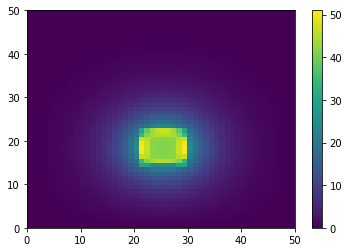

In [115]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

# box size, m
w = h = 1
# intervals in x-, y- directions, m
dx = dy = 0.02
# Thermal conductivity W/(m-K)
thermal_conductivity = 0.6
# Thermal diffusivity, m2.s-1
alphaSoil =  2.08e-7 #2.08e-7 m^2/s
alphaSteel = 1.172e-5 #m^2/s 1.172e-5 m^2/s
alphaWater = 1.39e-7 #m^2/s 1.39e-7 m^2/s
alphaSheat = 5e-8
# Porosity
n = 0.4
# Viscosity kg/m
mu = 1.00E-03 
# Permeability m2
k = 5E-10
# Thermal expansion 
beta = 8.80E-05
# Cf
cf = 4290
# rhow
rhow = 980
# gravity
g = 9.81 

# Set conduction to 0 to disable
conduction = 1.
convection = 0.

# Temperature of the cable
Tcool, Thot = 0, 70

# Flux
qx, qy = 3.15e2, 3.15e2


# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = 0.02, 0.49, 0.5
r2 = r**2

# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
cr1, cx1, cy1 = 0.02, 0.5, 0.45
cr1r2 = cr1**2

# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
cr2, cx2, cy2 = 0.02, 0.5, 0.55
cr2r2 = cr2**2

# pipe geometry
pr, pri, px, py = 0.1, 0.07, 0.62, 0.5 #0.59, 0.5
pr2 = pr**2
pri2 = pri**2

# Rayleigh number
ra = (rhow * g * (h -cx) * k * beta * (Thot-Tcool))/(mu*alphaSoil)
print("Rayleigh-Darcy number: {}".format(ra))

# Calculations
nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
#dt = dx2 * dy2 / (2 * alphaSoil * (dx2 + dy2))

dt = 0.0001 * 3600
#print("dt: {}, computed dt: {} critical dt: {}".format(dt, dx2 * dy2 / (2 * alphaSoil * (dx2 + dy2)), 1/(2 * alphaSoil * (dx2 + dy2))))

alpha = alphaSoil * np.ones((nx, ny))
u0 = Tcool * np.ones((nx, ny))
u = u0.copy()
uu = []

flux = np.zeros((nx, ny))
fluxx = np.zeros((nx, ny))
fluxy = np.zeros((nx, ny))

fflux = []
ffluxx = []
ffluxy = []


# Initial conditions
for i in range(nx):
    for j in range(ny):
        #pipe
        if ((i*dx-px)**2 + (j*dy-py)**2) < pr2:
            u0[i,j] = 0
        
        if (i*dx <= (px + pri + dx) and  i*dx >= (px - pri - dx)) and \
           (j*dy <= (py + pri + dx) and  j*dy >= (py - pri - dx)):
            # +i quadrant
            if (i*dx >= (px + pri - dx/2) and  i*dx <= (px + pri + dx/2)):
                alpha[i,j] = alphaSheat
            # -i quadrant
            elif (i*dx >= (px - pri - dx/2) and  i*dx <= (px - pri + dx/2)): 
                alpha[i,j] = alphaSheat
            # + j quadrant
            elif (j*dy >= (py + pri - dy/2) and  j*dy <= (py + pri + dy/2)):
                alpha[i,j] = alphaSheat
            # -j quadrant
            elif (j*dy >= (py - pri - dy/2) and  j*dy <= (py - pri + dy/2)):
                alpha[i,j] = alphaSheat
        
            
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit            
def do_timestep(u0, u, flux, fluxx, fluxy):
    # Propagate with forward-difference in time, central-difference in space, upwind solution for convection
    # Convection velocity term:
    # The velocity corresponds to differential density, since we are measuring the differnetial temp,
    # the rho(1 - beta(T)) is written as rho*(beta*DeltaT)
    '''
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + \
     + conduction * a[1:-1,1:-1] * dt * ((u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2 + \
          (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2) + \
    dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[1:-1,1:-1]-Tcool)) * \
    (u0[2:,1:-1] - u0[1:-1,1:-1])/(dy)
    '''
    # Set flux to zero
    flux = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            if i > 0 and j > 0 and i < (nx -1) and j < (ny -1):
                # The velocity corresponds to differential density, since we are measuring the differnetial temp,
                # the rho(1 - beta(T)) is written as rho*(beta*DeltaT)
                u[i, j] = u0[i, j] + \
                    + conduction * dt * thermal_conductivity * ((np.minimum(alpha[i, j], alpha[i+1, j]) *(u0[i+1, j] - u0[i,j]) + \
                                          np.minimum(alpha[i, j], alpha[i-1, j]) * (u0[i-1, j] - u0[i, j]))/dy2 + \
                                          (np.minimum(alpha[i, j], alpha[i, j+1]) * (u0[i, j+1] - u0[i,j]) + \
                                           np.minimum(alpha[i, j], alpha[i, j-1]) * (u0[i,j-1] - u0[i,j]))/dx2) + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy) * convection
            #pipe
            #if ((i*dx-px)**2 + (j*dy-py)**2) < pr2:
            #    u0[i,j] = Thot
            if (i*dx <= (px + pri + dx) and  i*dx >= (px - pri - dx)) and \
               (j*dy <= (py + pri + dx) and  j*dy >= (py - pri - dx)):
                # +i quadrant
                if (i*dx >= (px + pri - dx/2) and  i*dx <= (px + pri + dx/2)):
                    bi, bj = i-1, j
                    qxs, qys = 0, -1.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt * thermal_conductivity * (alpha[i, j]*(2 * u0[bi, bj] - 2 * (u0[i,j] + dy*qy*qys)))/dy2 + \
                                          (np.minimum(alpha[i, j], alpha[i, j+1]) * (u0[i, j+1] - u0[i,j]) + \
                                           np.minimum(alpha[i, j], alpha[i, j-1]) * (u0[i,j-1] - u0[i,j]))/dx2 + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy) * convection
                # -i quadrant
                elif (i*dx >= (px - pri - dx/2) and  i*dx <= (px - pri + dx/2)):
                    bi, bj = i+1, j
                    qxs, qys = 0, -1.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt * thermal_conductivity * (alpha[i, j]*(2 * u0[bi, bj] - 2 * (u0[i,j] + dy*qy*qys)))/dy2 + \
                                          (np.minimum(alpha[i, j], alpha[i, j+1]) * (u0[i, j+1] - u0[i,j]) + \
                                           np.minimum(alpha[i, j], alpha[i, j-1]) * (u0[i,j-1] - u0[i,j]))/dx2 + \
                                                       dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                       (u0[i+1,j] - u0[i,j])/(dy) * convection

                # + j quadrant
                elif (j*dy >= (py + pri - dy/2) and  j*dy <= (py + pri + dy/2)):
                    bi, bj = i, j-1
                    qxs, qys = -1, 0.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt * thermal_conductivity * ((np.minimum(alpha[i, j], alpha[i+1, j]) *(u0[i+1, j] - u0[i,j]) + \
                                          np.minimum(alpha[i, j], alpha[i-1, j]) * (u0[i-1, j] - u0[i, j]))/dy2 + \
                                           (alpha[i, j]*(2 * u0[bi, bj] - 2 * (u0[i,j] + dx*qx*qxs)))/dx2) + \
                                                       dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                       (u0[i+1,j] - u0[i,j])/(dy) * convection

                # -j quadrant
                elif (j*dy >= (py - pri - dy/2) and  j*dy <= (py - pri + dy/2)):
                    bi, bj = i, j+1
                    qxs, qys = -1, 0.
                    u[i, j] = u0[i, j] + \
                        + conduction * dt * thermal_conductivity * ((np.minimum(alpha[i, j], alpha[i+1, j]) *(u0[i+1, j] - u0[i,j]) + \
                                          np.minimum(alpha[i, j], alpha[i-1, j]) * (u0[i-1, j] - u0[i, j]))/dy2 + \
                                           (alpha[i, j]*(2 * u0[bi, bj] - 2 * (u0[i,j] + dx*qx*qxs)))/dx2) + \
                                                        dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[i,j]-Tcool)) * \
                                                        (u0[i+1,j] - u0[i,j])/(dy)    * convection

            #Flux around cable
            # -k * dT/dx
            if (((i*dx-cx)**2 + (j*dy-cy)**2) < (r2 + dx**2) and ((i*dx-cx)**2 + (j*dy-cy)**2) > (r2 - dx**2)) or (((i*dx-cx1)**2 + (j*dy-cy1)**2) < (cr1r2 + dx**2) and ((i*dx-cx1)**2 + (j*dy-cy1)**2) > (cr1r2 - dx**2)) or  (((i*dx-cx2)**2 + (j*dy-cy2)**2) < (cr2r2 + dx**2) and ((i*dx-cx2)**2 + (j*dy-cy2)**2) > (cr2r2 - dx**2)):
                fluxx[i,j] = - thermal_conductivity * (u0[i,j-1] - u0[i, j+1])/(2*dx)
                fluxy[i,j] = - thermal_conductivity * (u0[i-1,j] - u0[i+1, j])/(2*dy)
                flux[i,j] = np.sqrt(fluxx[i,j]**2 + fluxy[i,j]**2)

            
    u0 = u.copy()
    return u0, u, flux, fluxx, fluxy

# Number of timesteps
nsteps = 500001
npercent = int(nsteps/100)
id = 0
fluxt = []
for m in range(nsteps):
    u0, u, flux, fluxx, fluxy = do_timestep(u0, u, flux, fluxx, fluxy)
    if m % (npercent*10) == 0:
        uu.append(u.copy())
        fflux.append(flux.copy())
        ffluxx.append(fluxx.copy())
        ffluxy.append(fluxy.copy())
        print("Completed: {} % flux: {} u: {} max: {} Ra: {}".format(m/npercent, np.sum(flux[47:54, 42:58]), np.sum(uu[id]), np.max(uu[id]), ra * np.max(uu[id])/Thot))
        fluxt.append(np.sum(flux[47:54, 42:58]))
        id = id + 1


print("Conduction: ", conduction)
print("Total simulation time: {} hours".format(dt * nsteps / 3600))

fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[len(uu)-1]))
#plt.xticks([0,40,80,120,160,200],[0,20,40,60,80,100])
#plt.yticks([0,40,80,120,160,200],[0,20,40,60,80,100])
plt.colorbar()
plt.show()


#heat = u[:,50]
#np.savetxt("heat.csv", heat, delimiter=",")

#np.savetxt("flux.csv", fluxt, delimiter=",")

#pcm = plt.pcolormesh(np.flipud(fflux[len(fflux)-1]))
#plt.colorbar()    
#plt.show()
